In [14]:
import numpy as np
import matplotlib
matplotlib.use(backend="TkAgg")
import matplotlib.pyplot as plt
import pyart
from pathlib import Path
import radarIQ

In [15]:
cfTime = 100
sampDeg = 0.5
beamOverlap = 0
t = radarIQ.io.raxpolrkc.staticCfradNum2RkcNum(Path().cwd(), 'may232024', cfTime, sampDeg, beamOverlap)
radar = pyart.io.read(radarIQ.io.raxpolrkc.staticGetExistingCfrad(Path().cwd(), 'may232024', t, sampDeg, beamOverlap))
az_vals = np.arange(0., 360., sampDeg)
range_vals = radar.range['data']
range_vals_km = range_vals/1000

In [16]:
%matplotlib tk

disp = radarIQ.viz.iPyart('F:\py\cases\may232024\out\s0.5o0', cfTime)

In [17]:
meso_center = {
    'r_km': None,
    'az': None,
    'x': None,
    'y': None
}
spectrum_range = {
    'az': None,
    'ranges': [None, None]
}
def dblclick(event):
    if event.dblclick:
        global t
        x = event.xdata
        y = event.ydata
        if meso_center['r_km'] is None:
            r_km, az = radarIQ.misc.coordConvert.cart2polar(x,y)
            iaz = np.argmin(np.abs(az_vals - az))
            az = az_vals[iaz]

            dr_km = range_vals_km[1]-range_vals_km[0]
            r_km = (dr_km/2) * round(r_km / (dr_km/2))

            plt_x, plt_y = radarIQ.misc.coordConvert.polar2cart(r_km, az)

            disp.plot(('scatter', plt_x, plt_y, 'b'))
            event.canvas.draw()
            event.canvas.flush_events()

            meso_center['r_km'] = r_km
            meso_center['az'] = az
            meso_center['x'] = plt_x
            meso_center['y'] = plt_y
            disp.setCustomTitle("Doubleclick to set spectrum azimuth.")
        elif spectrum_range['az'] is None:
            _, az = radarIQ.misc.coordConvert.cart2polar(x,y)
            
            d_az = np.abs(az_vals - az)
            iaz = np.argmin(d_az)

            endx, endy = radarIQ.misc.coordConvert.polar2cart(range_vals_km[-1], az_vals[iaz])
            plt_x = [0, endx]
            plt_y = [0, endy]

            disp.plot(('plot', plt_x, plt_y, 'r'))
            event.canvas.draw()
            event.canvas.flush_events()

            spectrum_range['az'] = az_vals[iaz]
            disp.setCustomTitle("Doubleclick to set spectrum range bound.")
        elif spectrum_range['ranges'][0] is None:
            r_km, _ = radarIQ.misc.coordConvert.cart2polar(x,y)

            dr_km = np.abs(range_vals_km - r_km)
            irange = np.argmin(dr_km)
            
            plt_x, plt_y = radarIQ.misc.coordConvert.polar2cart(range_vals_km[irange], spectrum_range['az'])

            disp.plot(('scatter', plt_x, plt_y, 'g'))
            event.canvas.draw()
            event.canvas.flush_events()

            spectrum_range['ranges'][0] = range_vals_km[irange]
            disp.setCustomTitle("Doubleclick to set other spectrum range bound.")
        elif spectrum_range['ranges'][1] is None:
            r_km, _ = radarIQ.misc.coordConvert.cart2polar(x,y)

            dr_km = np.abs(range_vals_km - r_km)
            irange = np.argmin(dr_km)

            plt_x, plt_y = radarIQ.misc.coordConvert.polar2cart(range_vals_km[irange], spectrum_range['az'])

            disp.plot(('scatter', plt_x, plt_y, 'g'))
            event.canvas.draw()
            event.canvas.flush_events()

            spectrum_range['ranges'][1] = range_vals_km[irange]
            spectrum_range['ranges'].sort()

            xstart, ystart = radarIQ.misc.coordConvert.polar2cart(spectrum_range['ranges'][0], spectrum_range['az'])
            xend, yend = radarIQ.misc.coordConvert.polar2cart(spectrum_range['ranges'][1], spectrum_range['az'])
            plt_x = [xstart, xend]
            plt_y = [ystart, yend]

            disp.plot(('plot', plt_x, plt_y, 'g'))
            event.canvas.draw()
            event.canvas.flush_events()
            disp.setCustomTitle("Doubleclick to confirm selection.")
        else:
            t = disp.getFileNum()
            t = radarIQ.io.raxpolrkc.staticCfradNum2RkcNum(Path().cwd(), 'may232024', t, sampDeg, beamOverlap)
            plt.close()
disp.addCustomHandler('button_press_event', dblclick)
disp.setCustomTitle("Doubleclick to set mesocyclone centerpoint.")

In [18]:
disp.open()

In [19]:
t

128

In [20]:
radar = pyart.io.read(radarIQ.io.raxpolrkc.staticGetExistingCfrad(Path().cwd(), 'may232024', t, sampDeg, beamOverlap))

In [21]:
az_vals = radar.azimuth['data']
range_vals = radar.range['data']
range_vals_km = range_vals/1000

spectrum_range['iaz'] = np.argmin(np.abs(az_vals - spectrum_range['az']))
spectrum_range['iranges'] = []
spectrum_range['iranges'].append(np.argmin(np.abs(range_vals_km - spectrum_range['ranges'][0])))
spectrum_range['iranges'].append(np.argmin(np.abs(range_vals_km - spectrum_range['ranges'][1])))

In [22]:
spectrum_range

{'az': 33.0, 'ranges': [8.655, 11.715], 'iaz': 76, 'iranges': [288, 390]}

In [23]:
from datetime import datetime
time = datetime.fromisoformat(radar.metadata['start_datetime'])
timeStr = time.strftime('%m/%d/%Y %H:%M Z')

In [24]:
from netCDF4 import Dataset
data = radarIQ.io.raxpolrkc(Path().cwd(), 'may232024', t)
data.filterBadData()
dataset = Dataset(data.getExistingCfrad(sampDeg, beamOverlap))
boundaries = dataset['pulse_boundaries'][spectrum_range['iaz']]
dataset.close()

Filename: f:\py\..\may232024\RAXPOL-20240524-003702.092.rkc
preface = RadarKit/IQ   buildNo = 7
Pulse data size: 1388389184
gateCount = 12458   capacity = 36000   downSampledGateCount = 1246
data offset = 4792
Reading pulses ...
Number of pulses: 68978


In [25]:
pulses = data.pulses[boundaries[0]:boundaries[1]+1]
    
az = pulses['azimuthDegrees']
el = pulses['elevationDegrees']

pulses = pulses['iq'].transpose((1,2,3,0))
pulses = pulses[0,:,:,:] + 1.j*pulses[1,:,:,:]
pulses = pulses.transpose((0,2,1)).astype(np.complex128)

c = 299792458.0

ng = pulses.shape[0]
ns = pulses.shape[1]
gstep = 1

wavelength = data.header['desc']['wavelength']
prf_hz = round(1/data.header['config']['prt'])

if data.header['buildNo'] >= 4:
    if data.header['dataType'] == 'raw':
        dr = data.header['config']['pulseGateSize']
        dt = dr * 2 / (c/1e6)
    elif data.header['dataType'] == 'compressed':
        dr = data.header['desc']['pulseToRayRatio'] * data.header['config']['pulseGateSize']
        dt = dr * 2 / (c/1e6)
    else:
        print("Inconsistency detected. This should not happen.")
        dr = 30.
        dt = 1./50
else:
    dr = 30.
    dt = 1./50

va = wavelength * 0.25 * prf_hz

iqh = pulses[:,:,0]
iqv = pulses[:,:,1]

N0 = {
    'H': data.header['config']['noise'][0],
    'V': data.header['config']['noise'][1]
}

In [26]:
K = 1
dpsd_strat = 1

In [27]:
tV = {
    'H': iqh[spectrum_range['iranges'][0]:spectrum_range['iranges'][1]+1,:],
    'V': iqv[spectrum_range['iranges'][0]:spectrum_range['iranges'][1]+1,:]
}
w = np.blackman(ns)

In [28]:
E = radarIQ.proc.bootstrapDPSD(tV, w, N0, None, 20, K, spectrum_range['iranges'][1]+1-spectrum_range['iranges'][0])

In [29]:
E['sR'].shape

(103, 330)

In [30]:
snrh = 10*np.log10(E['sSNR']['H'])
snrv = 10*np.log10(E['sSNR']['V'])
ZDR = 10*np.log10(E['sD']) + data.header['config']['systemDCal']
rhoHV = np.array(E['sR'])

maskval = 20
mask = (snrh > maskval)

snrh[~mask] = np.nan
snrv[~mask] = np.nan
ZDR[~mask] = np.nan
rhoHV[~mask] = np.nan

In [31]:
np.count_nonzero(~np.isnan(rhoHV))

8058

3.0


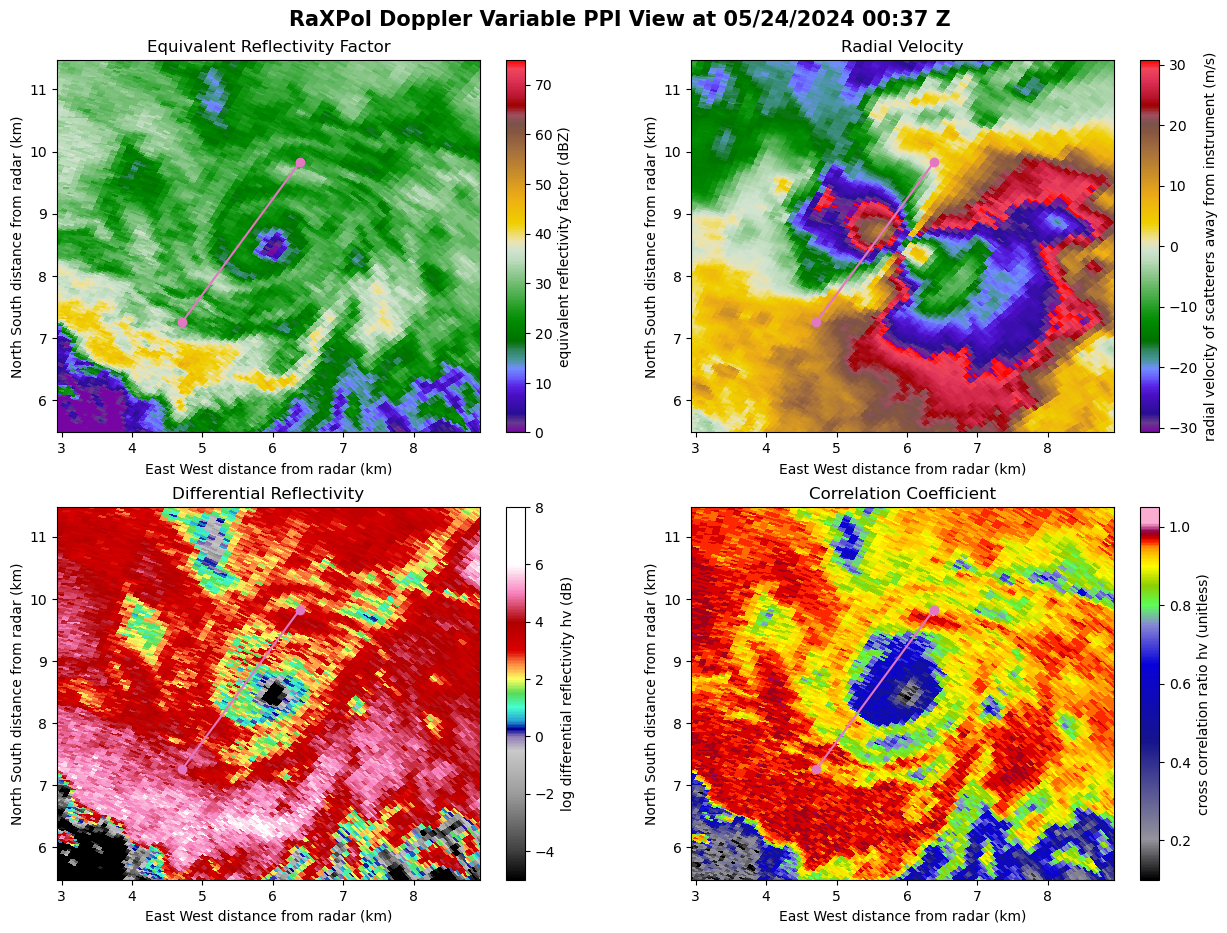

In [32]:
%matplotlib inline
display = pyart.graph.RadarDisplay(radar)
fields_to_plot = {
    'DBZ': {
        'ranges': (0, 75),
        'cmap': 'pyart_Carbone42',
        'title': 'Equivalent Reflectivity Factor'
    },
    'VEL': {
        'ranges': (-radar.get_nyquist_vel(0), radar.get_nyquist_vel(0)),
        'cmap': 'pyart_Carbone42',
        'title': 'Radial Velocity'
    },
    'ZDR': {
        'ranges': (-5, 8),
        'cmap': radarIQ.viz.cmaps.dmap(256),
        'title': 'Differential Reflectivity'
    },
    'RHOHV': {
        'ranges': (0.1, 1.05),
        'cmap': radarIQ.viz.cmaps.rmap(256),
        'title': 'Correlation Coefficient'
    } 
}

xstart, ystart = radarIQ.misc.coordConvert.polar2cart(range_vals_km[spectrum_range['iranges'][0]], az_vals[spectrum_range['iaz']])
xend, yend = radarIQ.misc.coordConvert.polar2cart(range_vals_km[spectrum_range['iranges'][1]], az_vals[spectrum_range['iaz']])
plt_x = [xstart, xend]
plt_y = [ystart, yend]

half_plot_size = np.ceil(np.abs(np.array(
    [xstart-meso_center['x'], xend-meso_center['x'], ystart-meso_center['y'], yend-meso_center['y']]
)).max()) + 1
print(half_plot_size)

xlim = (meso_center['x']-half_plot_size, meso_center['x']+half_plot_size)
ylim = (meso_center['y']-half_plot_size, meso_center['y']+half_plot_size)
plt.figure(figsize=[15, 10])

for plot_num, field in enumerate(fields_to_plot.keys()):
    vmin, vmax = fields_to_plot[field]['ranges']
    cmap = fields_to_plot[field]['cmap']

    plt.subplot(2, 2, plot_num+1)
    display.plot_ppi(field, vmin=vmin, vmax=vmax, cmap=cmap, title_flag=False)
    display.set_limits(xlim=xlim, ylim=ylim)
    plt.title(fields_to_plot[field]['title'])

    #line
    plt.scatter(plt_x, plt_y, color='tab:pink')
    plt.plot(plt_x, plt_y, color='tab:pink')

plt.subplots_adjust(top=0.93)
plt.suptitle('RaXPol Doppler Variable PPI View at ' + timeStr, weight='bold', fontsize=15)
plt.show()

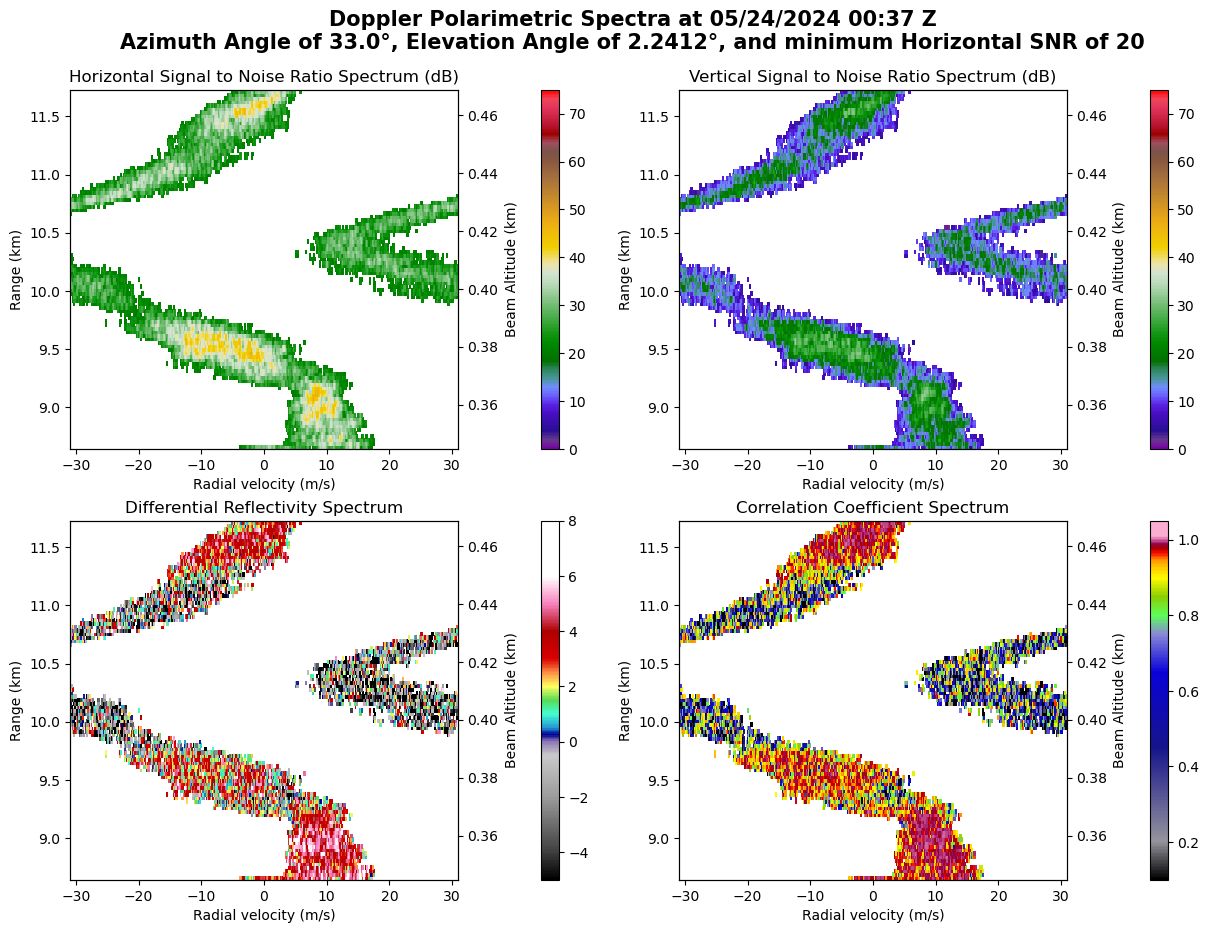

In [33]:
dpsd_fields = {
    'snrh': {
        'title': 'Horizontal Signal to Noise Ratio Spectrum (dB)',
        'data': snrh,
        'ranges': (0, 75),
        'cmap': 'pyart_Carbone42',
    },
    'snrv': {
        'title': 'Vertical Signal to Noise Ratio Spectrum (dB)',
        'data': snrv,
        'ranges': (0, 75),
        'cmap': 'pyart_Carbone42',
    },
    'ZDR': {
        'title': 'Differential Reflectivity Spectrum',
        'data': ZDR,
        'ranges': (-5, 8),
        'cmap': radarIQ.viz.cmaps.dmap(256),
    },
    'rhoHV': {
        'title': 'Correlation Coefficient Spectrum',
        'data': rhoHV,
        'ranges': (0.1, 1.05),
        'cmap': radarIQ.viz.cmaps.rmap(256),
    }
}

ny, nx = snrh.shape
x_axis = np.linspace(-va, va, nx)

r_unique = range_vals_km[spectrum_range["iranges"][0]:spectrum_range["iranges"][1]+1]
el_angle = radar.elevation['data'][spectrum_range['iaz']]
rad_ht_km = radar.altitude['data'][0]/1000
al_unique = np.sqrt((r_unique)**2 + ((4/3)*6371 + rad_ht_km)**2 + 2*r_unique*((4/3)*6371+rad_ht_km)*np.sin(np.radians(el_angle))) - (4/3)*6371

fig = plt.figure(figsize=[15, 10])
for plot_num, field in enumerate(dpsd_fields.keys()):
    title = dpsd_fields[field]["title"]
    dpsd = dpsd_fields[field]['data']
    vmin, vmax = dpsd_fields[field]['ranges']
    cmap = dpsd_fields[field]['cmap']

    plt.subplot(2, 2, plot_num+1)
    plt.pcolor(x_axis, r_unique, dpsd, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.title(title)
    plt.xlabel('Radial velocity (m/s)')
    plt.ylabel('Range (km)')
    plt.colorbar(pad=0.15)
    plt.twinx()
    plt.ylim([al_unique[0], al_unique[-1]])
    plt.ylabel('Beam Altitude (km)')

plt.subplots_adjust(top=0.9, wspace=0.1)
plt.suptitle(
    'Doppler Polarimetric Spectra at ' + timeStr + '\n' +
    'Azimuth Angle of ' + str(az_vals[spectrum_range['iaz']]) + '°, Elevation Angle of ' +
    str(round(el_angle, 4)) + '°, and minimum Horizontal SNR of ' + str(maskval),
    weight='bold', fontsize=15
)
plt.show()